In [1]:
import pandas as pd
fraud = pd.read_csv('onlinefraud.csv',nrows=10000)


In [2]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Check for Null Values
fraud.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
encoding = pd.get_dummies(fraud, columns=['type'], drop_first=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
encoding[columns_to_scale] = scaler.fit_transform(encoding[columns_to_scale])

In [6]:
import sqlite3
conn = sqlite3.connect('onlinefraud.db')
encoding.to_sql('transactions', conn, if_exists='replace', index=False)

10000

## Exploratory Data Analysis

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
fraud_count = fraud['isFraud'].value_counts()
fraud_count

isFraud
0    9932
1      68
Name: count, dtype: int64

In [9]:
x  = 68 / 9932
x

0.00684655658477648

#### This means that only .6% of payments were fraudulent!

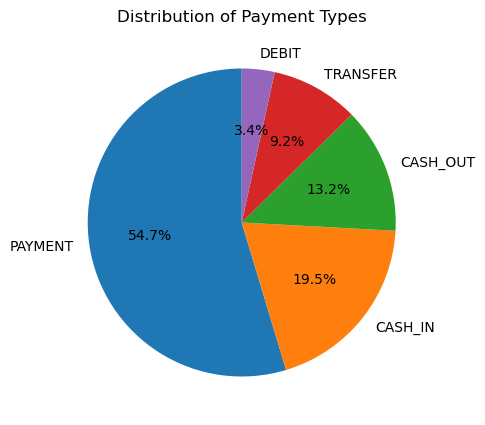

In [10]:
payment_counts = fraud['type'].value_counts()
plt.figure(figsize=(5, 5))  
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Payment Types")
plt.show()


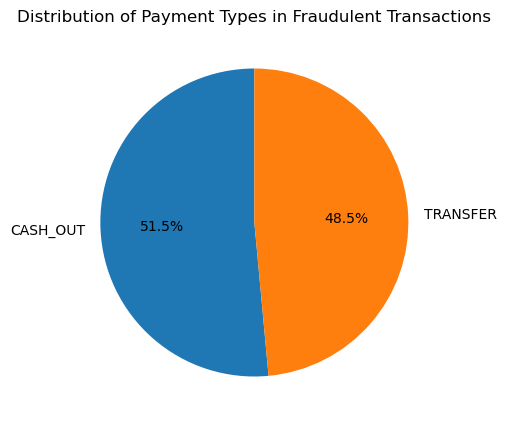

In [11]:
#Subsets the dataset to include only fraudulent transactions
fraudulent_transactions = fraud[fraud['isFraud'] == 1]

fraudulent_payment_counts = fraudulent_transactions['type'].value_counts()

plt.figure(figsize=(5, 5))  
plt.pie(fraudulent_payment_counts, labels=fraudulent_payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Payment Types in Fraudulent Transactions")
plt.show()

### Very Interesting! It appears the the only type of fraudulent transactions are either cash_out or transfers!

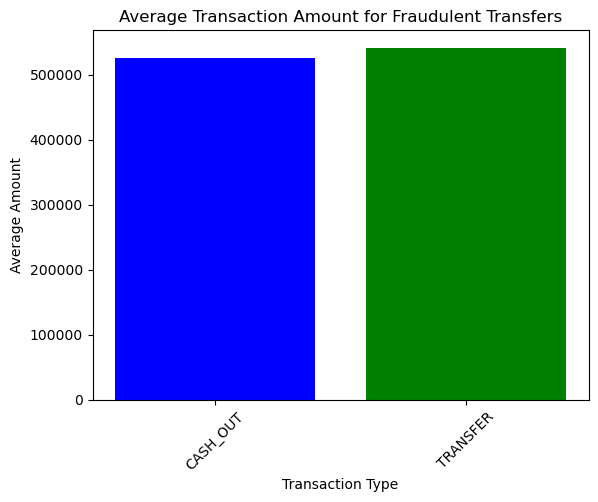

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("fraud_data.db")
fraud.to_sql('fraud_transactions', conn, index=False, if_exists='replace')


# SQL query to calculate the average transaction amount for fraudulent transactions
query = """
SELECT type, AVG(amount) AS avg_amount
FROM fraud_transactions
WHERE isFraud = 1 AND type IN ('CASH_OUT', 'TRANSFER')
GROUP BY type;
"""

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plot the data
plt.bar(df['type'], df['avg_amount'], color=['blue', 'green'])
plt.title("Average Transaction Amount for Fraudulent Transfers")
plt.xlabel("Transaction Type")
plt.ylabel("Average Amount")
plt.xticks(rotation=45)
plt.show()


### This means that fraudulent 'transfers' have slightly higher amounts compared to fraudulent 'cash_out's

### I want to delve deeper into this, so I plotted the average amount for both legitimate and fraudulent transactions

In [ ]:
import sqlite3

conn = sqlite3.connect('fraud_data.db') 

fraud.to_sql('fraud_transactions', conn, index=False, if_exists='replace')

conn.execute('CREATE INDEX IF NOT EXISTS idx_isFraud ON fraud_transactions(isFraud);')

query = """
SELECT isFraud, 
       AVG(amount) AS avg_amount, 
       AVG(oldbalanceOrg) AS avg_oldbalanceOrg,
       AVG(newbalanceOrig) AS avg_newbalanceOrig
FROM fraud_transactions
GROUP BY isFraud;
"""

fraud_by_type_sql = pd.read_sql(query, conn)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of variables to plot
variables = ['avg_amount', 'avg_oldbalanceOrg', 'avg_newbalanceOrig']
titles = ['Average Amount', 'Average Old Balance', 'Average New Balance']


for i, var in enumerate(variables):
    ax = axes[i]
    data = fraud_by_type_sql.groupby('isFraud')[var].mean()
    ax.bar(['Legitimate', 'Fraudulent'], data, color=['green', 'red'])
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)', fontsize=12)
    ax.set_ylabel(f'Average {titles[i]}', fontsize=12)
    ax.set_ylim(0, data.max() * 1.2)
plt.tight_layout()
plt.show()
conn.close()


### Interesting! We've scaled the data, which is why the values range from 0 to 1. 

### It's very clear that fraudulent transactions have much higher amounts than legitimate ones. Additionally, fraudulent transactions leave much lower newer balances compared to legitimate ones.

#### Another interesting note, it appears that fraudulent transactions happen to people with lower balances. Interesting note


## Model Development
### Lets develop models to predict fraudulent transactions

In [15]:
standard = 1-x
print("My goal is to build a prediction model that has a higher accuracy rate than", standard)

My goal is to build a prediction model that has a higher accuracy rate than 0.9931534434152235


### Logistic Regression

In [16]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [17]:
# One hot encoding
X = encoding.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = encoding['isFraud']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


data = pd.read_csv('onlinefraud.csv',nrows=5000)
data = data.drop(['nameOrig', 'nameDest'], axis=1)

data = pd.get_dummies(data, columns=['type'], drop_first=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)  
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1488
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.98      0.99      0.99      1500



/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Because this model is overbalanced, Logistic Regression is struggling to accurately identify fraudulent models. Let's try other methods

### RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


print("Random Forest Report:")
print(classification_report(y_test, rf_preds))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])}")


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       1.00      0.50      0.67        12

    accuracy                           1.00      1500
   macro avg       1.00      0.75      0.83      1500
weighted avg       1.00      1.00      1.00      1500

AUC-ROC Score: 0.9998039874551972


#### While this is better, it can only identify fraudulent transactions at a 50% rate. Let's work on this and improve it

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. Oversample the Minority Class (SMOTE)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 2. Adjust Class Weights
rf_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10})

# 3. Perform Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)

# Use the best model
best_rf_model = grid_search.best_estimator_

# 4. Evaluate the Best Model
rf_preds = best_rf_model.predict(X_test)
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, rf_preds))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_probs)}")

# 5. Adjust Prediction Threshold for Recall
threshold = 0.3  # Experiment with this value
rf_preds_threshold = (rf_probs >= threshold).astype(int)

print("Random Forest Report (Adjusted Threshold):")
print(classification_report(y_test, rf_preds_threshold))
print(f"AUC-ROC Score (Adjusted Threshold): {roc_auc_score(y_test, rf_probs)}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       0.59      0.83      0.69        12

    accuracy                           0.99      1500
   macro avg       0.79      0.91      0.84      1500
weighted avg       1.00      0.99      0.99      1500

AUC-ROC Score: 0.9972278225806451
Random Forest Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1488
           1       0.50      0.92      0.65        12

    accuracy                           0.99      1500
   macro avg       0.75      0.95      0.82      1500
weighted avg       1.00      0.99      0.99      1500

AUC-ROC Score (Adjusted Threshold): 0.9972278225806451


###
Default Threshold (0.5)
Metrics Breakdown:

    Precision (1): 0.59
        Of all transactions predicted as fraud, 59% were actually fraudulent.
        There are some false positives, but it’s reasonable given the recall improvement.

    Recall (1): 0.83
        The model successfully identified 83% of fraudulent transactions.
        This is a significant improvement over the previous models, reducing the number of false negatives (missed frauds).

    F1-Score (1): 0.69
        A harmonic mean of precision and recall for fraudulent transactions. A higher F1-score indicates a good balance between precision and recall.

    AUC-ROC Score: 0.9972
        The model has excellent discriminatory power, distinguishing between legitimate and fraudulent transactions very well, and beats our goal of building a model with a higher accuracy rate than 0.9931534434152235!!!

Adjusted Threshold (0.3)
Metrics Breakdown:

    Precision (1): 0.50
        Precision dropped because lowering the threshold leads to more transactions being predicted as fraud (increasing false positives).

    Recall (1): 0.92
        Recall increased to 92%, meaning the model now catches nearly all fraudulent transactions.
        This is critical in scenarios where missing a fraudulent transaction is costlier than a false alarm.

    F1-Score (1): 0.65
        The F1-score slightly dropped due to the trade-off between precision and recall, but recall improvement compensates for this.

    Accuracy:
        Accuracy remains very high (99%), but it’s less informative due to class imbalance (legitimate transactions dominate).

    AUC-ROC Score: 0.9972
        The AUC-ROC score remains unchanged, as it evaluates the model's ability to rank predictions rather than its classification threshold.

Key Insights

    Default Threshold (0.5):
        Good balance between precision and recall.
        Better suited for scenarios where precision is as important as recall (e.g., avoiding false positives to minimize investigation costs).

    Adjusted Threshold (0.3):
        High recall ensures nearly all fraudulent transactions are identified.
        Ideal for scenarios where missing fraud (false negatives) has a significant cost or risk.

### Simulating a transaction

In [24]:
# Simulate a transaction
new_transaction = {
    'step': 5,
    'amount': 5000,
    'oldbalanceOrg': 20000,
    'newbalanceOrig': 15000,
    'oldbalanceDest': 0,
    'newbalanceDest': 0,
    'type_CASH_OUT': 0,
    'type_PAYMENT': 1,
    'type_TRANSFER': 0,
    'type_DEBIT': 0,
    'type_DEPOSIT': 0
}

# Convert to DataFrame
new_transaction_df = pd.DataFrame([new_transaction])

# Normalize numerical data
new_transaction_df[columns_to_scale] = scaler.transform(new_transaction_df[columns_to_scale])

# Predict fraud
# Ensure the transaction data has the same columns as the training data
# Get the columns from the training data
columns_in_training = X_train.columns  # or list of columns used during training

# Ensure new transaction has the same columns
new_transaction_df = new_transaction_df[columns_in_training]

# Normalize numerical data (only scale numerical features that were scaled during training)
new_transaction_df[columns_to_scale] = scaler.transform(new_transaction_df[columns_to_scale])

# Predict fraud
fraud_prediction = best_rf_model.predict(new_transaction_df)
print("Fraud Detected!" if fraud_prediction[0] == 1 else "Transaction Safe")



Transaction Safe
